In [ ]:
"""
Deep CNN used to detect Pneumonia from X-ray images. 
Accuracy of the model: 91.19 %
"""

In [ ]:
# Import necessary libraries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential 
from keras.layers import Dense, SeparableConv2D, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import cv2
import os


In [ ]:
# Loading dataset 

labels = ['PNEUMONIA', 'NORMAL']
img_size = 150 

def load_data(data_dir):
  data = []
  for label in labels:
    path = os.path.join(data_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
      try: 
        img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        resized_arr = cv2.resize(img_arr, (img_size, img_size))
        data.append([resized_arr, class_num])
      except Exception as e:
        print(e)
  return np.array(data)


In [ ]:
# Execute Load data from google drive folder to Colab

train = load_data('/content/drive/MyDrive/Colab Notebooks/input/chest_xray/chest_xray/train')
test = load_data('/content/drive/MyDrive/Colab Notebooks/input/chest_xray/chest_xray/test')
val = load_data('/content/drive/MyDrive/Colab Notebooks/input/chest_xray/chest_xray/val')


OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


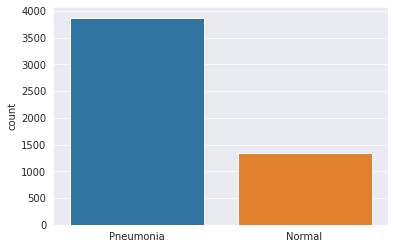

In [ ]:
# Visualise data to see count of each image class
# The number of Pneumonia images to Normal images is imbalanced, so we'll use data augmentation in the following cell

l = []
for i in train:
  if(i[1] == 0):
    l.append("Pneumonia")
  else:
    l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'NORMAL')

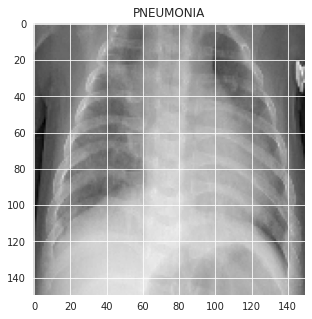

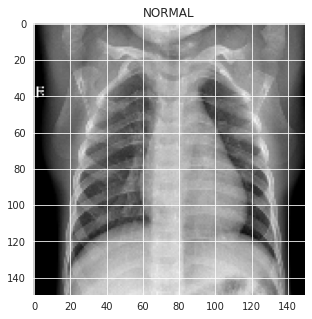

In [ ]:
# Previewing images of both classes

plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap = 'gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap = 'gray')
plt.title(labels[train[-1][1]])

In [ ]:
# Split data into images and labels for each set, so we can normalize the images

x_train = []
y_train = []

x_test = []
y_test = []

x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in test:
  x_test.append(feature)
  y_test.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)


In [ ]:
# We perform a greyscale normalisation to reduce the effect of illumination differences
# the CNN converges faster on [0..1] than [0..255]

x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255
x_val = np.array(x_val) / 255


In [ ]:
# Reshape the data to the correct dimensions (-1,150,150,1) for Keras 
# First dimensions as -1 means that we dont know how much should be in the first dimension

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [ ]:
# Artificially expand dataset using ImageDataGenerator 

datagen = ImageDataGenerator(
    featurewise_center = False, 
    samplewise_center = False, 
    featurewise_std_normalization = False, 
    samplewise_std_normalization = False,
    zca_whitening = False,
    rotation_range = 30,
    zoom_range = 0.2, 
    width_shift_range = 0.1, 
    height_shift_range = 0.1, 
    horizontal_flip = True, 
    vertical_flip = False)

datagen.fit(x_train)

In [ ]:
# Build Model 

model = Sequential()

# First Conv block
model.add(Conv2D(16 , (3,3) , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(Conv2D(16 , (3,3), padding = 'same' , activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

# Second Conv block
model.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))

# Third Conv block
model.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))

# Forth Conv block
model.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

# Fifth Conv block 
model.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

# FC layer 
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.7))
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(units = 1 , activation = 'sigmoid'))

# Compile
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

# Callbacks 
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, verbose = 1, mode='min', restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 150, 150, 16)      160       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d_24 (Separab (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_25 (Separab (None, 75, 75, 32)        1344      
_________________________________________________________________
batch_normalization_12 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 37, 37, 32)       

In [ ]:
# Train Model 

history = model.fit(
    datagen.flow(x_train, y_train, batch_size = 32), 
    epochs = 12, 
    validation_data = datagen.flow(x_val, y_val), 
    callbacks = [checkpoint, learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 241s 1s/step - loss: 0.4664 - accuracy: 0.7729 - val_loss: 0.7864 - val_accuracy: 0.5000
Epoch 2/12
163/163 [==============================] - 242s 1s/step - loss: 0.2908 - accuracy: 0.8828 - val_loss: 0.8122 - val_accuracy: 0.5000
Epoch 3/12
163/163 [==============================] - 239s 1s/step - loss: 0.2379 - accuracy: 0.9094 - val_loss: 1.5675 - val_accuracy: 0.5000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/12
163/163 [==============================] - 240s 1s/step - loss: 0.1990 - accuracy: 0.9221 - val_loss: 1.7602 - val_accuracy: 0.5000
Epoch 5/12
163/163 [==============================] - 242s 1s/step - loss: 0.2026 - accuracy: 0.9234 - val_loss: 1.3344 - val_accuracy: 0.6250
Epoch 6/12
163/163 [==============================] - 239s 1s/step - loss: 0.1536 - accuracy: 0.9446 - val_loss: 2.0884 - val_accuracy: 0.5000
Epoch 7/12
163/163 [==============================] - 241s 1s

In [ ]:
# Save model 	
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1)

In [ ]:
# Evaluating the model on the test data

print("Loss of the model is - ", model.evaluate(x_test, y_test)[0])
print("Accuracy of the model is - ", model.evaluate(x_test, y_test)[1]*100, "%")

20/20 [==============================] - 8s 377ms/step - loss: 0.2786 - accuracy: 0.9119
Loss of the model is -  0.2786322236061096
20/20 [==============================] - 8s 379ms/step - loss: 0.2786 - accuracy: 0.9119
Accuracy of the model is -  91.18589758872986 %


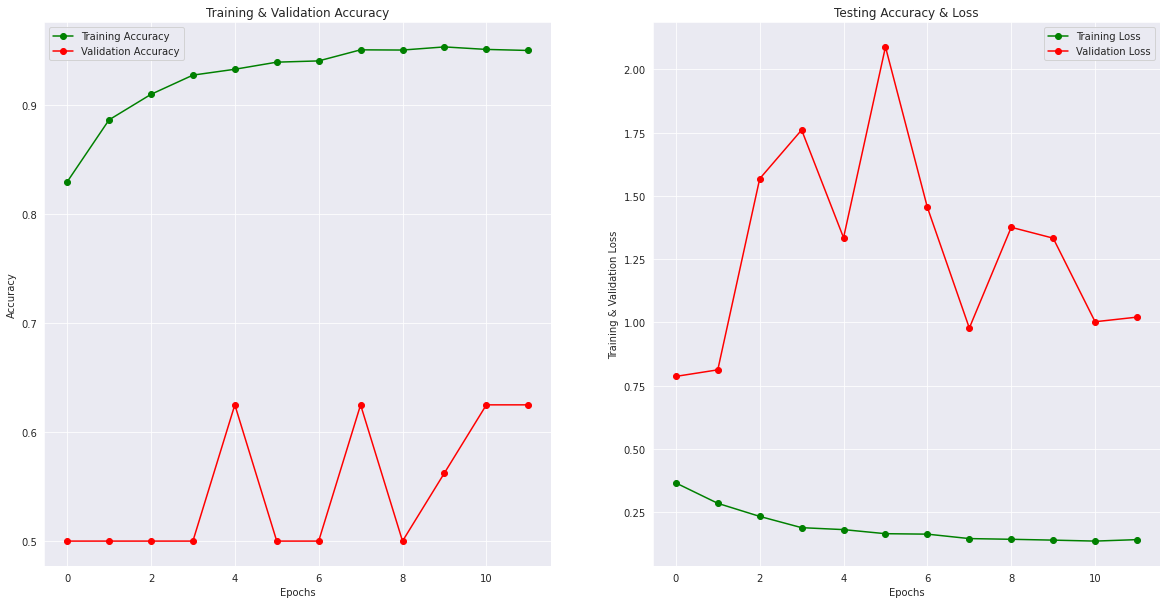

In [ ]:
# Create Accuracy and Loss charts

epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = model.predict_classes(x_test)
predictions - predictions.reshape(1,-1)[0]
predictions[:15]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)', 'Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.89      0.97      0.93       390
   Normal (Class 1)       0.95      0.81      0.87       234

           accuracy                           0.91       624
          macro avg       0.92      0.89      0.90       624
       weighted avg       0.91      0.91      0.91       624



In [ ]:
# Create confusion matrix

cm = confusion_matrix(y_test, predictions)
cm 

array([[380,  10],
       [ 45, 189]])

In [ ]:
cm = pd.DataFrame(cm, index = ['0', '1'], columns = ['0', '1'])

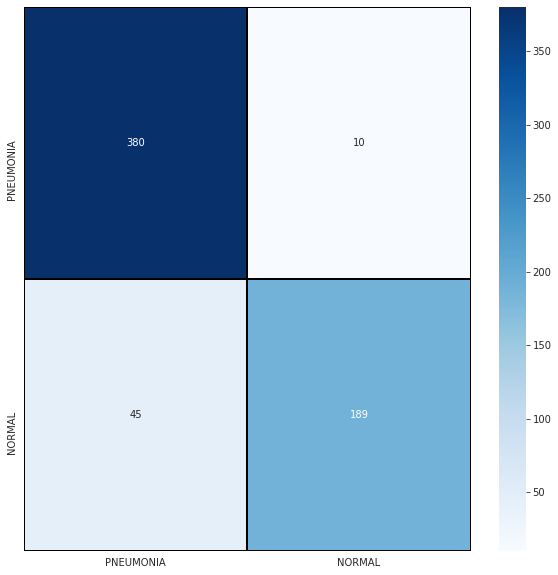

In [ ]:
# Confusion matrix plot

plt.figure(figsize = (10,10))
sns.heatmap(
    cm, 
    cmap = 'Blues', 
    linecolor = 'black', 
    linewidth = 1, 
    annot = True, 
    fmt = '', 
    xticklabels = labels, 
    yticklabels = labels)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

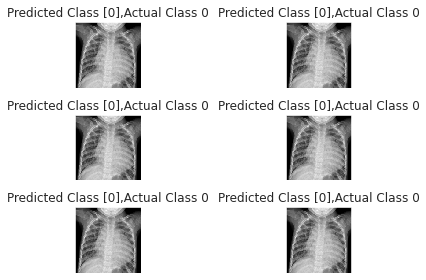

In [ ]:
# Sample of correctly predicted classes

i = 0
for c in correct[:6]:
  plt.subplot(3,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
  plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
  plt.tight_layout()
  i += 1

In [1]:
# Sample of incorrectly predicted classes 

i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

NameError: ignored

In [ ]:
# ideas for improvement: 
# K-fold validation for a better measure of the stochastic variance.
# Imbalanced dataset leading to poor results on "Normal" images. add more images to this class

In [ ]:
while True:pass